# Autoencoding our variables

### Import the python torch and tensorflow modules and make sure we're ready to rock and roll

In [1]:
import os
import sys
import torch

import tensorflow as tf
from tensorflow.keras import layers, models

if not torch.cuda.is_available():
    print("FATAL: Please run this notebook in an environment with CUDA available", file=sys.stderr)
else:
    print("Lets go GPU", file=sys.stderr)

2024-12-30 10:07:50.891595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Lets go GPU


## Import the libraries.

This is my standard import.

In [2]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import json
import random

from itertools import cycle
from collections import Counter

import networkx as nx
import community

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor, ClassifierChain
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress
from scipy.cluster.hierarchy import linkage, fcluster

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'


from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

import cf_analysis_lib


from adjustText import adjust_text

## Read the data

In [3]:
sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

## Somewhere to save the outputs!

In [4]:
outdir = 'cluster_gbrfs'
os.makedirs(outdir, exist_ok=True)

### Split the data

In [5]:
training_data, validate_data = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train: {training_data.shape}")
print(f"Test: {validate_data.shape}")

Train: (101, 1512)
Test: (26, 1512)


## Develop the autoencoder

Because an autoencoder reconstructs its inputs, the “labels” (y) are the same as the features (X), so `x=training_data`, and `y=training_data`.

In [6]:
# 1) Define network parameters
input_dim = len(df.columns)
latent_dim = 50  # tweak this

# 2) Build the encoder
encoder_input = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(512, activation='relu')(encoder_input)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
encoder_output = layers.Dense(latent_dim, activation='linear')(x)

# 3) Build the decoder
decoder_input = layers.Input(shape=(latent_dim,))
y = layers.Dense(128, activation='relu')(decoder_input)
y = layers.Dense(512, activation='relu')(y)
decoder_output = layers.Dense(input_dim, activation='linear')(y)

# 4) Create autoencoder
encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")
decoder = tf.keras.Model(decoder_input, decoder_output, name="decoder")

autoencoder_input = tf.keras.Input(shape=(input_dim,))
encoded = encoder(autoencoder_input)
decoded = decoder(encoded)

autoencoder = tf.keras.Model(autoencoder_input, decoded, name="autoencoder")

# 5) Compile & train
autoencoder.compile(optimizer='adam', loss='mse')
result = autoencoder.fit(
    x=training_data,
    y=training_data,
    epochs=200,
    batch_size=16,
    validation_data=(validate_data, validate_data),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# 6) Extract low-dimensional features
train_latent = encoder.predict(training_data)
val_latent = encoder.predict(validate_data)
all_data = encoder.predict(df)

2024-12-30 10:07:55.917104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:41:00.0, compute capability: 7.0


Epoch 1/200


2024-12-30 10:07:58.415740: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555587056980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-30 10:07:58.415792: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-12-30 10:07:58.421978: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-30 10:07:58.438948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-12-30 10:07:58.566403: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - 3s 45ms/step - loss: 101666728.0000 - val_loss: 91335888.0000
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 69161104.0000 - val_loss: 46533252.0000
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 47791912.0000 - val_loss: 38568560.0000
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 42665460.0000 - val_loss: 32465982.0000
Epoch 5/200
7/7 [==============================] - 0s 10ms/step - loss: 37541600.0000 - val_loss: 26456382.0000
Epoch 6/200
7/7 [==============================] - 0s 10ms/step - loss: 31943994.0000 - val_loss: 19928706.0000
Epoch 7/200
7/7 [==============================] - 0s 10ms/step - loss: 26206856.0000 - val_loss: 14697558.0000
Epoch 8/200
7/7 [==============================] - 0s 10ms/step - loss: 21642706.0000 - val_loss: 11278092.0000
Epoch 9/200
7/7 [==============================] - 0s 10ms/step - loss: 18645094.0000 - val_loss: 9456766.0000
Epoc

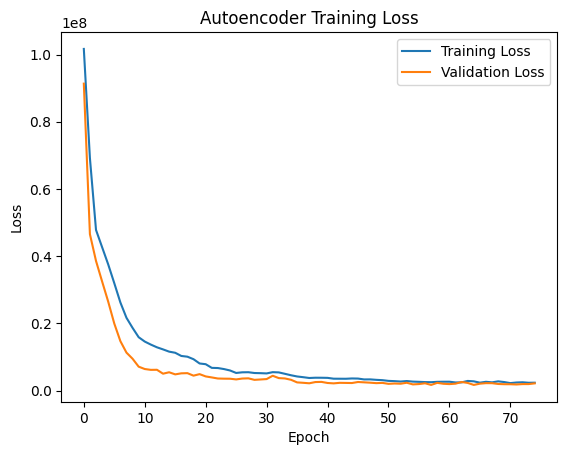

In [7]:
# Plot training & validation loss
plt.plot(result.history['loss'], label='Training Loss')
plt.plot(result.history['val_loss'], label='Validation Loss')

plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict which original features cluster

Looking at the correlation to the encoded data

We compute Correlation Between Each Original Feature and Each Latent Dimension

In [8]:
num_features = df.shape[1]  # 1512
num_latent_dims = all_data.shape[1]       # 50 - the number of output layers

corr_matrix = pd.DataFrame(index=df.columns, columns=[f"LD_{i}" for i in range(num_latent_dims)])

for i in range(num_features):
    for j in range(num_latent_dims):
        try:
            corr = np.corrcoef(df.iloc[:, i], all_data[:, j])[0, 1]
            corr_matrix.iloc[i, j] = corr
        except:
            print(f"Error predicting {i} and {j}", file=sys.stderr)
            break

corr_matrix = corr_matrix.astype(float)
corr_matrix.head()

,LD_0,LD_1,LD_2,LD_3,LD_4,LD_5,LD_6,LD_7,LD_8,LD_9,...,LD_40,LD_41,LD_42,LD_43,LD_44,LD_45,LD_46,LD_47,LD_48,LD_49
"2,3-diacetamido-2,3-dideoxy-d-mannuronic acid",-0.048336,-0.109762,-0.259658,-0.085992,-0.370577,0.202002,-0.194037,0.138273,-0.198119,-0.053817,...,-0.218871,0.124563,-0.153066,-0.009746,0.355634,-0.046805,0.102982,0.012385,-0.031333,0.033029
2-O-alpha-mannosyl-D-glycerate utilization,0.163423,0.209734,0.625776,0.421307,0.346976,0.219629,0.505154,-0.319989,-0.095674,0.159476,...,0.589332,0.233405,0.033707,0.094878,-0.764276,0.168358,0.142779,0.598363,-0.669777,-0.058044
2-aminophenol Metabolism,-0.179204,-0.088166,-0.112632,0.112662,-0.083849,0.361366,-0.147652,-0.147275,-0.306372,-0.149117,...,0.138545,0.325342,-0.148370,-0.230577,-0.015389,0.024901,0.040665,0.235886,-0.250317,-0.215241
2-ketoacid oxidoreductases disambiguation,-0.421633,-0.536249,-0.295797,-0.423424,-0.366662,-0.400367,-0.365722,-0.183924,-0.194821,-0.548092,...,-0.269293,0.126473,0.216912,-0.170257,0.660808,0.356535,0.412408,-0.345695,0.238026,0.130634
2-oxoglutarate dehydrogenase,-0.234746,-0.007478,-0.327024,-0.289162,0.072642,0.083032,-0.289580,0.212389,-0.152810,-0.217513,...,-0.131889,0.057525,-0.018862,-0.214923,0.423128,0.038919,-0.129402,-0.492278,0.383511,-0.176252


## Alternate way to do the clustering

Here, we take the correlation matrix from the ANN - correlating which of our 1512 features map to the same output nodes from the ANN and we build clusters using k-means hierarchical clustering.

The 150 clusters is somewhat random - it is ~10% of the input data and it only gives 3 singletons, and breaks the Pseudomonas cluster down quite a bit.

In [9]:
# Calculate linkage on the rows (i.e., the features)
Z = linkage(corr_matrix, method='ward', metric='euclidean')

k = 150  # more clusters, smaller groups!
clusters = fcluster(Z, k, criterion='maxclust')  # Each feature gets a cluster ID [1..k]

# create a df with the cluster assignments
cluster_assignments = pd.DataFrame({
    "Feature": corr_matrix.index,  # the feature names
    "Cluster": clusters
})
cluster_assignments.sort_values("Cluster", inplace=True)

### Print out the clusters that contain _Pseudomonas_ subsystems

In [10]:
interesting_cluster = None
interesting_cluster_count = 0
grouped = cluster_assignments.groupby("Cluster")
for cluster_id, group in grouped:
    if group['Feature'].str.contains('Pseudomonas').any():
        if group['Feature'].str.contains('Pseudomonas').sum() > interesting_cluster_count:
            interesting_cluster_count = group['Feature'].str.contains('Pseudomonas').sum()
            interesting_cluster = cluster_id
        print(f"--- Cluster {cluster_id} : Length {group['Feature'].shape[0]} ---")
        print(group["Feature"].tolist())
        print()

--- Cluster 59 : Length 44 ---
['Microbulbiferaceae', 'Cholera toxin', 'Biogenesis of cbb3-type cytochrome c oxidases', 'Potential DNA repair cluster', 'tRNA modification, 5-oxyacetyl uridine (cmo5U34)', 'Iron siderophore sensor & receptor system', 'Sulfate assimilation related cluster', 'L-2-amino-4-methoxy-trans-3-butenoic acid synthesis', 'Stress proteins YciF, YciE', 'Phenazine biosynthesis', 'Carbon storage regulator', 'Beta-lactamases Ambler class D', 'Colwelliaceae', 'CMP-pseudaminic acid synthesis', 'Possible heterocyst differentiation related cluster', 'Respiratory Systems - Shewanella (updated)', 'Heme and heme d1 biosynthesis from siroheme', 'Periplasmic nitrate reductase EC 1.7.99.4', 'Quorum sensing regulation in Pseudomonas', 'Outer membrane porins in Pseudomonas and Acinetobacter', 'Malonate decarboxylase', 'Pseudomonadaceae', 'Extracellular matrix proteins (PEL) involved in glucose-rich biofilm formation in Pseudomonas', 'Extracellular matrix proteins (PSL) involved in 

### How many singletons are there in the groups?

In [11]:
singletons = 0
for cluster_id, group in grouped:
    if group['Feature'].shape[0] == 1:
        singletons+=1
print(f"There are {singletons} single clusters")

There are 3 single clusters


## Write all the clusters out

This is so we can use them again!

In [12]:
grouped = cluster_assignments.groupby("Cluster")
with open(os.path.join(outdir, 'cluster_features.txt'), 'w') as out:
    for cluster_id, group in grouped:
        print(f"--- Cluster {cluster_id} : Length {group['Feature'].shape[0]} ---", file=out)
        print(group["Feature"].tolist(), file=out)
        print(file=out)
cluster_assignments.to_csv(os.path.join(outdir, 'clusters.tsv'), sep="\t", index=False)

In [13]:
intcol = 'Pseudomonas Culture'
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])
merged_df_clust.to_csv(os.path.join(outdir, 'Pseudomonas_cluster.tsv'), sep="\t")

### Cluster correlations

Now we have clusters, lets take one cluster and see how it correlates to itself.

Note that the ANN has learnt things that both positively and negatively correlate.

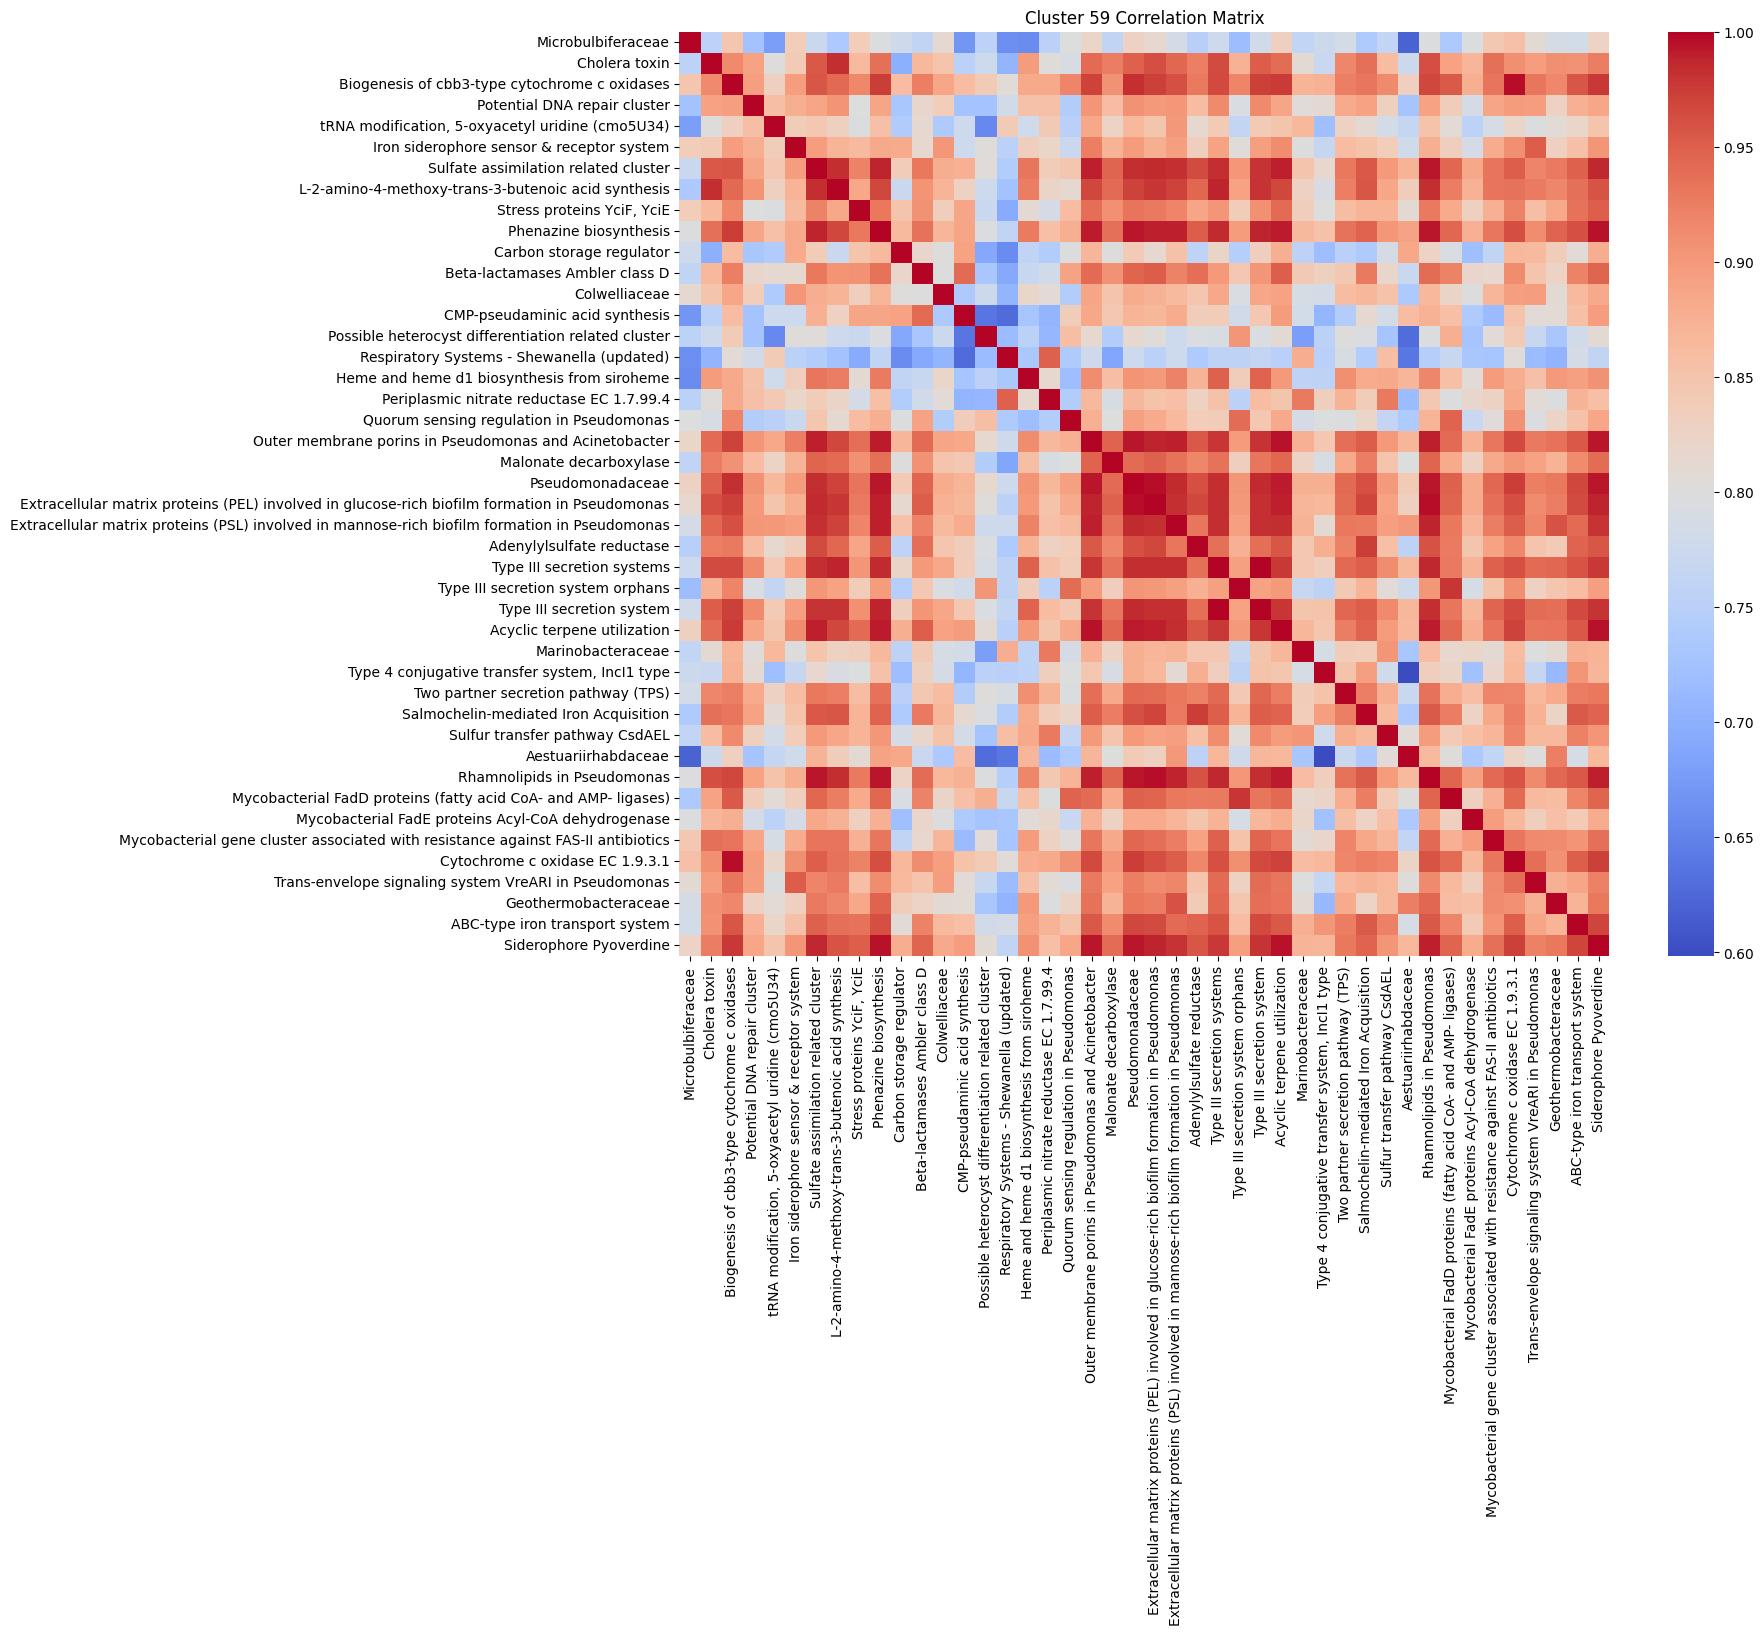

In [14]:
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
df_clust_corr = df_clust.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(df_clust_corr, annot=False, cmap='coolwarm')
plt.title(f'Cluster {interesting_cluster} Correlation Matrix')
plt.show()

## Creating a new df with principal components of the data

Here, we make a new data frame that has the PC1 for each _cluster_. This doesn't matter if the cluster has positive/negative correlations because we are looking at the PC.

We can use this matrix in our machine learning approaches like gradient boosted random forest!

In [15]:
pca = PCA(n_components=1)
pc_df = pd.DataFrame(index=df.index, columns=[f"Cluster {x+1}" for x in range(len(cluster_assignments.groupby("Cluster").size()))])
for cluster_id, group in grouped:
    df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == cluster_id, "Feature"]]
    pc_df[f"Cluster {cluster_id}"] = pca.fit_transform(df_clust).ravel()
pc_df

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,...,Cluster 141,Cluster 142,Cluster 143,Cluster 144,Cluster 145,Cluster 146,Cluster 147,Cluster 148,Cluster 149,Cluster 150
1068841_20180306_S,715.507023,313.442296,4623.486104,156.543181,-7.262040,1825.493547,97582.527423,1780.273818,676.245634,1334.751455,...,-953.492559,-1347.691196,-172.199388,-663.852204,-649.747397,-96.266925,-14741.323209,-301.192461,-129.498740,-686.371794
1447437_20171212_S,-45.881704,-617.546529,-691.525913,-636.835515,-33.608304,-3074.432724,-53458.096239,-1694.885008,-954.426044,1480.237427,...,6304.509991,445.168416,419.300045,-907.282106,-407.363538,-338.602287,22832.907381,-760.389843,-391.991347,77.675473
1128691_20171206_S,-1725.120119,-298.808866,-3221.863896,-918.414154,-286.348470,-7777.162530,-195353.148806,-1517.338286,-117.076290,-3924.153971,...,-1323.234623,749.613022,-581.539774,375.034778,1355.908709,-1137.639763,-52261.223197,-451.783736,556.189022,3412.909263
1128691_20171218_S,-1548.680605,-350.074901,-2897.009042,-886.915088,-245.302415,-6821.566689,-173495.186399,-1278.373816,89.723100,-3374.506576,...,-637.728924,367.492896,-458.262958,-139.443497,1225.695306,-980.609295,-37230.846176,621.945501,452.593994,3832.411140
1128691_20180116_S,-1949.175659,-720.585350,-3374.665872,-1229.655116,-226.791352,-7990.858318,-215985.383039,-2062.359338,262.599997,-4511.412645,...,-1730.599785,1248.646749,-587.127698,426.369811,1806.793488,-1033.498806,-39581.323819,-484.912293,513.596887,3463.399458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895293_20180502_S,8.526954,388.428873,-1539.617458,527.838480,-96.106536,-1250.545113,90351.749908,-757.856988,727.781008,-671.192287,...,-1183.900426,-489.148379,-174.596121,912.062981,579.903954,-175.864656,1188.507796,370.259264,-72.188388,-852.057631
896213_20180427_S,79.719672,-147.763505,1816.826362,51.341951,-139.606450,4213.174975,-42551.788144,56.510765,-514.414132,-1003.645570,...,-611.460297,2023.965311,-297.057333,-2.895321,-57.694035,-114.428627,-56252.782258,-1288.253084,-454.721087,-1658.726947
913873_20180417_S,-276.411538,-46.965915,3163.366217,-893.446153,34.391025,4897.076137,-1808.085607,-301.150029,-590.718180,-371.254996,...,724.779098,8.084030,-335.624667,-1124.728433,-894.261122,-454.456462,-54879.676589,-125.940066,-529.850491,-991.713329
980574_20180403_S,-136.346160,-288.426101,-976.339067,250.774604,-8.112787,-2754.431318,-2487.417301,-600.790775,32.358320,-483.783219,...,-541.276908,-1254.056107,139.604222,431.620055,-151.583260,-174.015696,14082.483621,-404.009110,-121.477884,-826.889243


### Plot a PCA

We just plot the PCA of one component to see what it looks like. This is our `interesting component`, of course, the one with all the Pseudomonodaceae

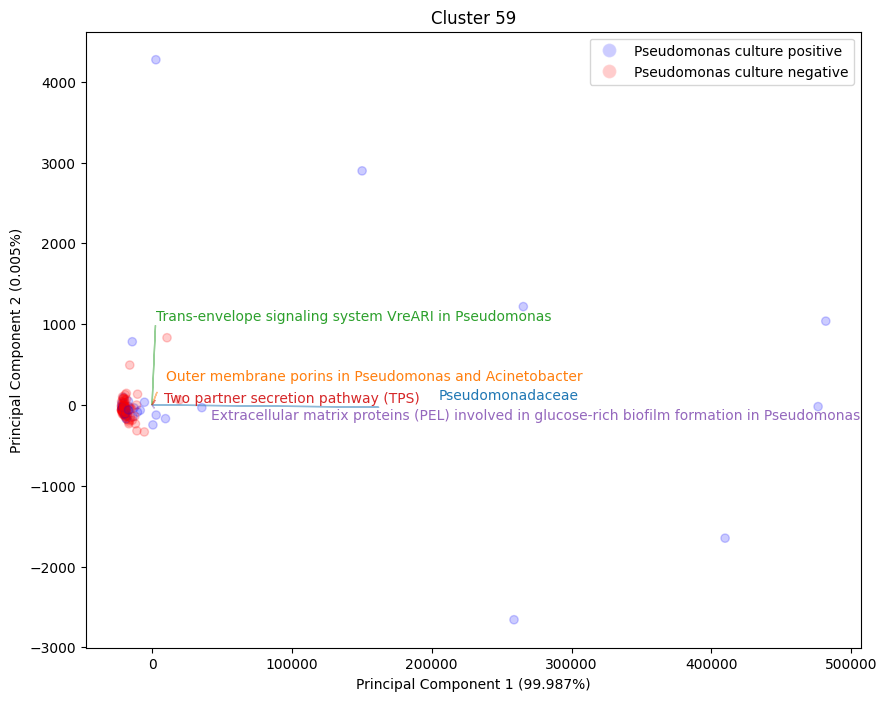

In [16]:
pca = PCA(n_components=2)

intcol = 'Pseudomonas Culture'
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])

pca_result = pca.fit_transform(df_clust)
pca_df = pd.DataFrame(data=pca_result, index=df.index, columns=['PC1', 'PC2'])

# Get loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=df_clust.columns, columns=['PC1', 'PC2'])

# Create a DataFrame for top loadings
top_loadings_df = loadings_df.loc[loadings_df['PC1'].abs().sort_values(ascending=False).index]
top_loadings_df.head()

explained_variance = pca.explained_variance_ratio_ * 100
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]

colours = np.where(merged_df_clust['Pseudomonas Culture'] == 1, 'blue', 'red')

# Plot the PCA results
plt.figure(figsize=(10, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.2, c=colours)
plt.title(f"Cluster {interesting_cluster}")
plt.xlabel(f'Principal Component 1 ({pc1_variance:.3f}%)')
plt.ylabel(f'Principal Component 2 ({pc2_variance:.3f}%)')

# add the loadings ... we only plot maxloadings here
maxloadings = 5
if len(loadings) < maxloadings:
    maxloadings = len(loadings)

plotscaler = 2
texts = []
colour_cycle = cycle(mcolors.TABLEAU_COLORS)
found_pseudomonas = False
for i in range(maxloadings):
    c = next(colour_cycle)
    xpos = top_loadings_df.iloc[i, 0]*plotscaler
    ypos = top_loadings_df.iloc[i, 1]*plotscaler
    plt.arrow(0, 0, xpos, ypos, 
              color=c, alpha=0.5, width=0.05)
    texts.append(plt.text(xpos, ypos, top_loadings_df.index[i], color=c))

adjust_text(texts)


# Add a legend
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture positive', 
                         markerfacecolor='blue', alpha=0.2, markersize=10)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='Pseudomonas culture negative', 
                        markerfacecolor='red', alpha=0.2, markersize=10)


plt.legend(handles=[blue_patch, red_patch])


# Show the plot
plt.show()

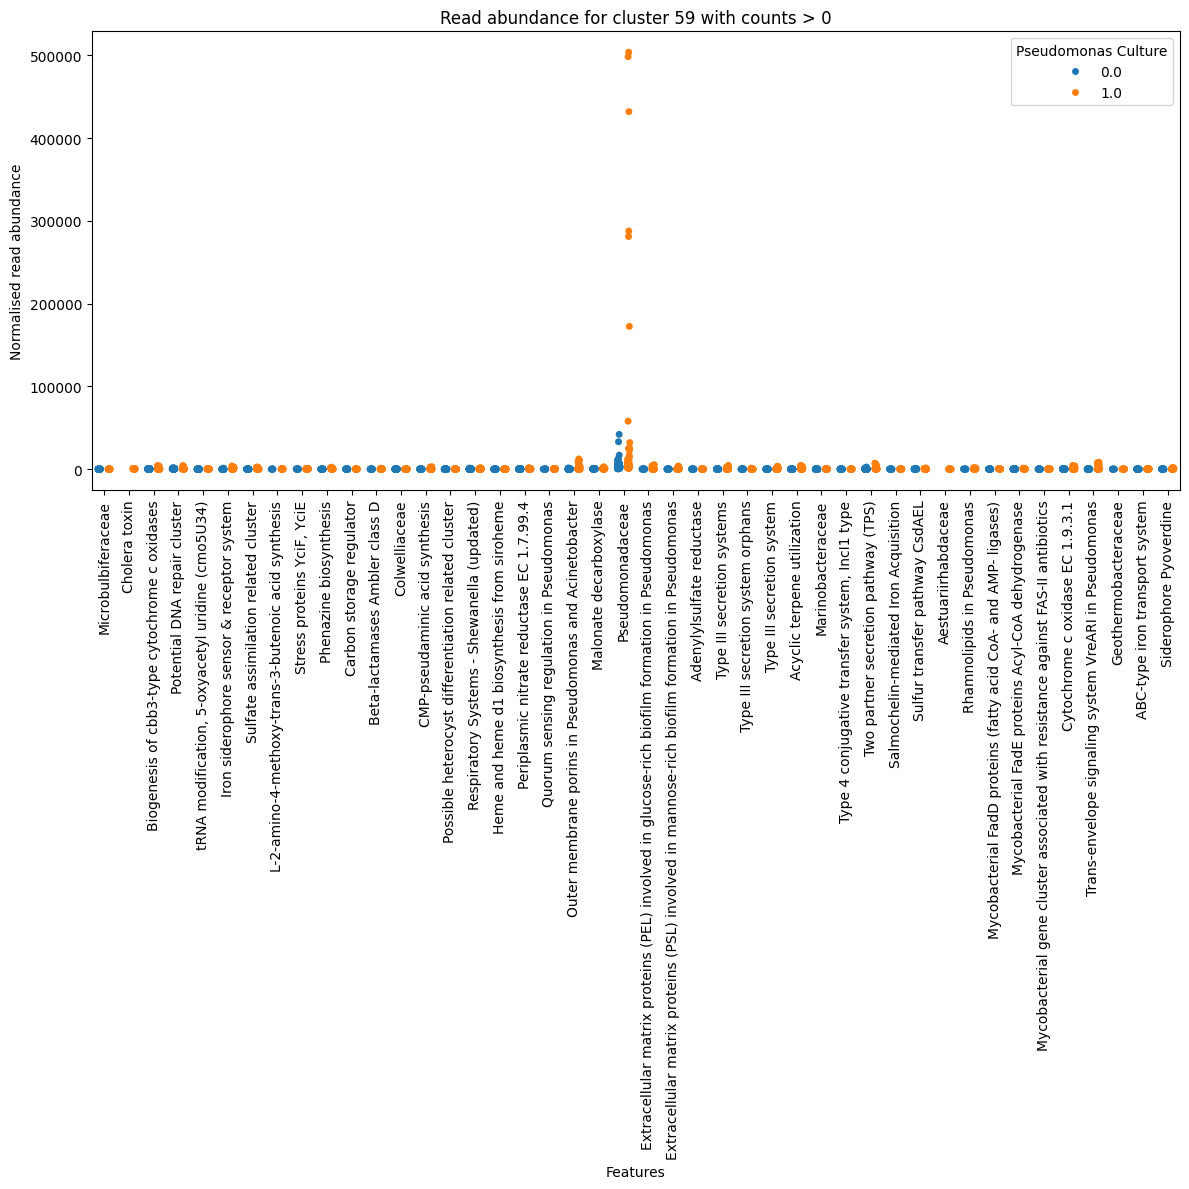

In [17]:
df_clust = df[cluster_assignments.loc[cluster_assignments["Cluster"] == interesting_cluster, "Feature"]]
merged_df_clust = df_clust.join(metadata[[intcol]])
df_clust_m = merged_df_clust.melt(id_vars=intcol, var_name='Features', value_name='Normalised read abundance')
df_clust_m = df_clust_m[df_clust_m['Normalised read abundance'] > 0]
plt.figure(figsize=(12, 12))
sns.stripplot(data=df_clust_m, x='Features', y='Normalised read abundance', hue=intcol, dodge=True, jitter=True)
plt.xticks(rotation=90)
# plt.ylim(0, 10000)
plt.title(f"Read abundance for cluster {interesting_cluster} with counts > 0")
plt.tight_layout()
plt.show()

# GBRF

This code is directly from the GBRF page, but we are using pc_df instead of df, and we're going to predict `Pseudomonas culture`

When we run this multiple times, we get the same answer! Now we only need to run the GBRF once per metadata column

Running the regressor on Pseudomonas Culture has an average mse of 0.15015420947032274


Cluster 59: 0.0543 (3 times)
Cluster 127: 0.0170 (3 times)
Cluster 72: 0.0164 (3 times)
Cluster 139: 0.0140 (3 times)
Cluster 114: 0.0139 (2 times)
Cluster 63: 0.0134 (2 times)
Cluster 106: 0.0125 (3 times)
Cluster 15: 0.0121 (2 times)
Cluster 74: 0.0108 (2 times)
Cluster 62: 0.0107 (2 times)


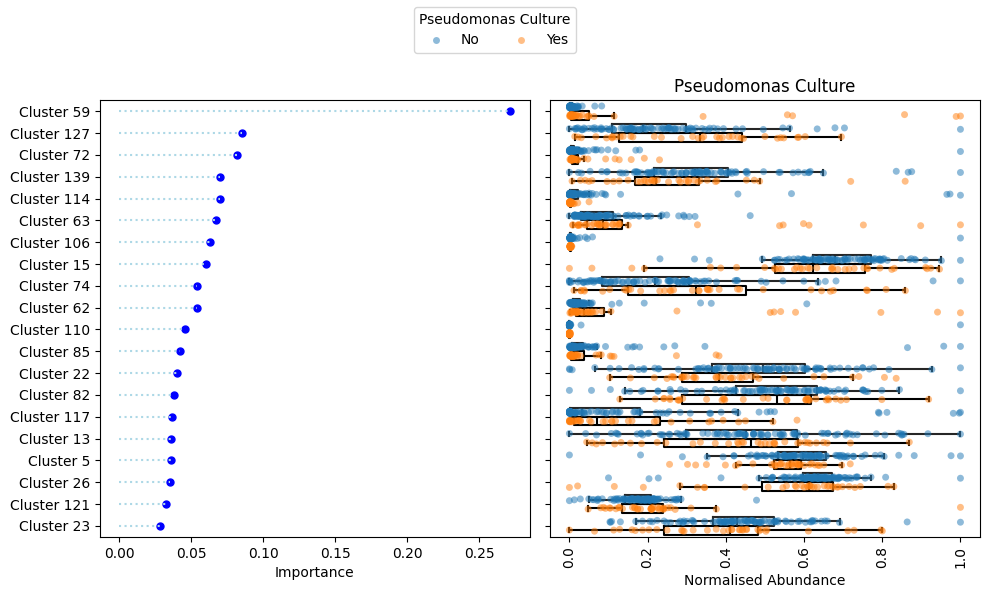

In [18]:
intcol = 'Pseudomonas Culture'

replace_index = re.compile(r'^\d+\s+')
intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

# do we need to encode this column
custom_labels = {0: 'No', 1: 'Yes'}
categorical_data = False
if pd.api.types.is_numeric_dtype(metadata[intcol]):
    # this is an numeric column, so we can just continue
    pass
elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype) and pd.api.types.is_numeric_dtype(metadata[intcol].cat.categories.dtype):
    # this is a categorical column with numeric categories so we can also continue
    categorical_data = True
elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype):
    # this is a categorical column with string categories so we need to encode it
    enc = OrdinalEncoder()
    metadata_encoder = enc.fit(metadata[[intcol]])
    categories = metadata_encoder.categories_[0]
    custom_labels = {code: cat for code, cat in enumerate(categories)}
    merged_df[intcol] = metadata_encoder.transform(metadata[[intcol]])
    categorical_data = True
else:
    # not sure what this is, so we skip it for now
    print(f"Error: {intcol} is not a numeric or categorical column, but carrying on", file=sys.stderr)
    

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

top_features = {}
top_feature_counts = {}
niterations = 3
msetot = 0
n=20
for i in range(niterations):
    if categorical_data:
      mse, feature_importances_sorted = cf_analysis_lib.gb_classifier(X, y)
      met = 'classifier'
    else:
      mse, feature_importances_sorted = cf_analysis_lib.gb_regressor(X, y)
      met = 'regressor'
    
    msetot += mse
    
    for f in feature_importances_sorted.index[:n]:
        top_features[f] = top_features.get(f, 0) + feature_importances_sorted.loc[f, 'importance']
        top_feature_counts[f] = top_feature_counts.get(f, 0) + 1

print(f"Running the {met} on {intcol_title} has an average mse of {msetot/niterations}", file=sys.stderr)

cf_analysis_lib.plot_top_features(merged_df, top_features, top_feature_counts, intcol, intcol_title, custom_labels)

# Run the GBRF for every metadata sample

This code is taken from the gradient_boosting.py script with some minor changes, but runs the GBRF once per sample.

In [ ]:
replace_index = re.compile(r'^\d+\s+')
replace_nonword = re.compile(r'\W+')

resultsfile = open(os.path.join(outdir, 'gbrf_results.txt'), 'w')
print(f"Predictor\tFeature\tImportance", file=resultsfile)

skip_columns = {'minion', 'MGI', 'pwCF_ID', 'Sample_Type'}

for intcol in metadata.columns:
    if intcol in skip_columns:
        continue
    print(f"Working on {intcol}", file=sys.stderr)

    # set up our titles and the filename
    intcol_title = replace_index.sub('', intcol)
    intcol_filename = intcol.replace(" ", "_")
    intcol_filename = replace_nonword.sub('', intcol_filename)

    merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

    # do we need to encode this column
    custom_labels = {0: 'No', 1: 'Yes'}
    categorical_data = False
    if pd.api.types.is_numeric_dtype(metadata[intcol]):
        # this is an numeric column, so we can just continue
        categorical_data = False
    elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype) and pd.api.types.is_numeric_dtype(metadata[intcol].cat.categories.dtype):
        # this is a categorical column with numeric categories so we can also continue
        categorical_data = True
    elif isinstance(metadata[intcol].dtype, pd.CategoricalDtype):
        # this is a categorical column with string categories so we need to encode it
        enc = OrdinalEncoder()
        metadata_encoder = enc.fit(metadata[[intcol]])
        categories = metadata_encoder.categories_[0]
        custom_labels = {code: cat for code, cat in enumerate(categories)}
        merged_df[intcol] = metadata_encoder.transform(metadata[[intcol]])
        categorical_data = True
    else:
        # not sure what this is, so we skip it for now
        print(f"Error: {intcol} is not a numeric or categorical column. Skipped", file=sys.stderr)
        continue

    X = merged_df.drop(intcol, axis=1)
    y = merged_df[intcol]


    met = None

    if categorical_data or metadata[intcol].dtype == 'object':
        mse, feature_importances_sorted = cf_analysis_lib.gb_classifier(X, y)
        met = 'classifier'
    else:
        mse, feature_importances_sorted = cf_analysis_lib.gb_regressor(X, y)
        met = 'regressor'

    print(f"Mean squared error for {intcol} using {met} is {mse}", file=resultsfile)
    
    print(f"Features appearing at least once", file=resultsfile)
    for x in feature_importances_sorted:
        print(f"{intcol}\t{x}\t{feature_importances_sorted[x]}", file=resultsfile)
        
    y_features = 10

    topN = list(feature_importances_sorted[:y_features].index) + [intcol]
    fig, axes = plt.subplots(figsize=(10, 6), nrows=1, ncols=2, sharey='row', sharex='col')
    cf_analysis_lib.plot_feature_importance(axes[0], feature_importances_sorted[:y_features][::-1], "")
    cf_analysis_lib.plot_feature_abundance(axes[1], merged_df[topN][::-1], intcol, intcol_title)


    handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
    updated_labels = labels
    try:
        updated_labels = [custom_labels[float(label)] for label in labels]
    except Exception as e:
        print(f"Couldn't use float for labels {e}.", file=sys.stderr)

    for ax in axes.flat:
        if ax.get_legend() is not None:  # Check if legend exists
            ax.get_legend().remove()

    plt.xticks(rotation=90)
    fig.legend(handles, updated_labels, loc='upper center', ncol=2, title=intcol_title)
    plt.tight_layout(rect=[0, 0, 1, 0.9])
    plt.savefig(os.path.join(outdir, f"{intcol_filename}.png"))
    plt.close()

resultsfile.close()

Working on Sample date
Error: Sample date is not a numeric or categorical column. Skipped
Working on IP vs OP
Working on Hospital
